In [1]:
import os
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torchvision

from unet import UNet
from dataset import BrainMriDataset

DATA_PATH = "./brain_mri"

In [2]:
image_to_mask = {}

for sub_folder in glob.glob(DATA_PATH + "/*"):
    for file in glob.glob(sub_folder + "/*"):
        if "mask" not in file:
            continue
        
        mask_path = file
        image_path = file.replace("_mask", "")
        if not os.path.exists(image_path):
            print("Orignal image not found for mask", mask_path.split('/')[-1])
            continue
        image_to_mask[image_path] = mask_path

In [3]:
file, images, masks = [], [], []
for image, mask in image_to_mask.items():
    file.append(image.split("/")[-1])
    images.append(cv2.imread(image))
    masks.append(cv2.imread(mask))

df = pd.DataFrame({"file": file, "image": images, "mask": masks})
df["diagnosis"] = df["mask"].apply(lambda mask : 1 if mask.max() > 0 else 0)

print(df.shape)
df.head()

(3929, 4)


,file,image,mask,diagnosis
0,TCGA_DU_6400_19830518_15.tif,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,TCGA_DU_6400_19830518_35.tif,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,TCGA_DU_6400_19830518_37.tif,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,TCGA_DU_6400_19830518_36.tif,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
4,TCGA_DU_6400_19830518_10.tif,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0


Showing: TCGA_DU_7299_19910417_11.tif


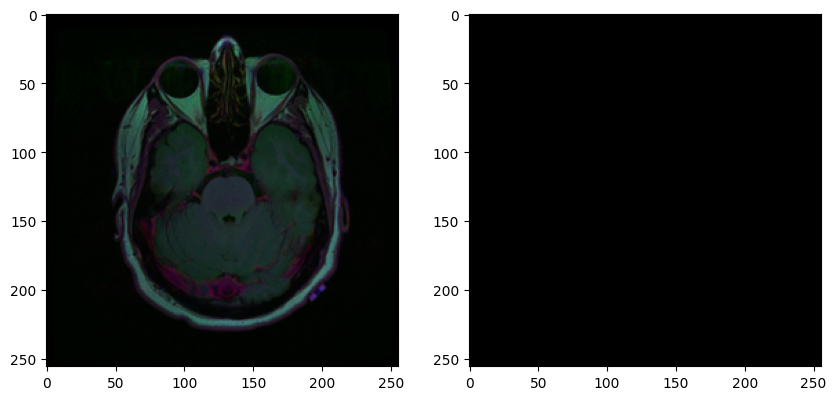

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sample = df.sample()
print(f"Showing: {sample["file"].values[0]}")

img = sample["image"].values[0]
mask = sample["mask"].values[0]

ax[0].imshow(img, cmap="gray")
ax[1].imshow(mask, cmap="gray")

<Axes: ylabel='count'>

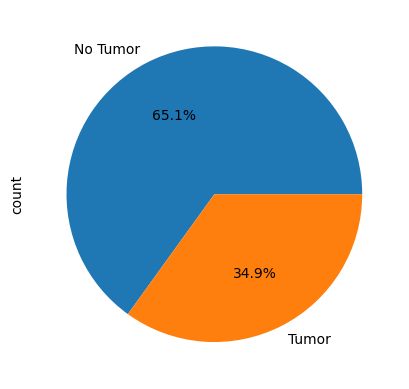

In [5]:
df['diagnosis'].value_counts().plot.pie(labels=["No Tumor", "Tumor"], autopct="%.1f%%")

In [6]:
d = df['diagnosis'].value_counts()
d

diagnosis
0    2556
1    1373
Name: count, dtype: int64

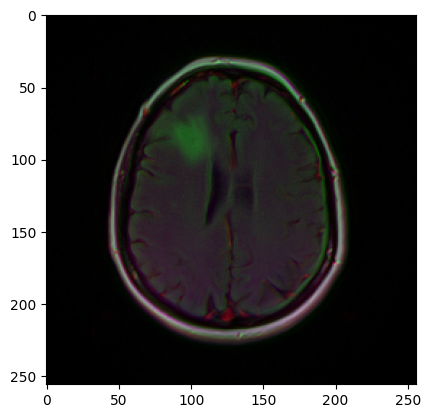

In [7]:
x = df["image"].sample().values[0]
y = torch.from_numpy(x.transpose(2,0,1)/255).type(torch.FloatTensor)
y = torchvision.transforms.ToPILImage()(y)

plt.imshow(y)

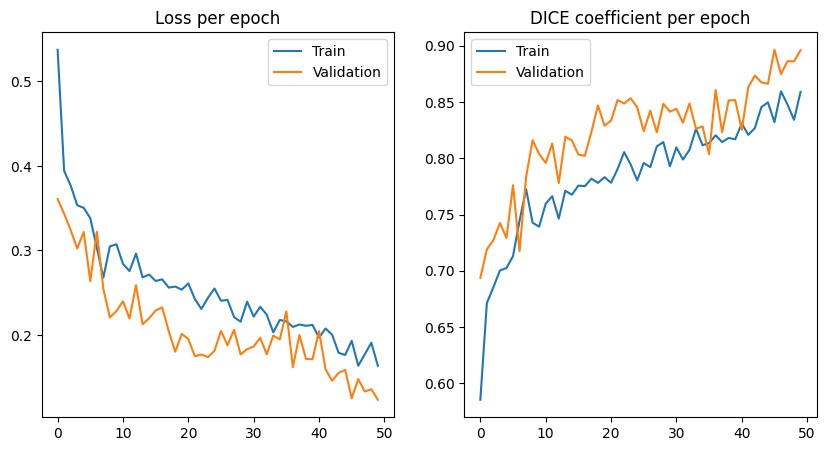

In [8]:
def ema(signal, alpha):
    ema = torch.zeros_like(signal)
    ema[0] = signal[0]
    for t in range(1, len(signal)):
        ema[t] = alpha * signal[t] + (1 - alpha) * ema[t - 1]
    return ema

def plot_curves(loss_curves, ax, title):
    ax.plot(loss_curves[0].cpu().detach().numpy())
    ax.plot(loss_curves[1].cpu().detach().numpy())
    ax.legend(["Train", "Validation"])
    ax.set_title(title)

loss_curves = torch.load("loss_curves.pt")
loss_curves = ema(loss_curves, 1)

dice_coeff_curves = torch.load("dice_coeff_curves.pt")
dice_coeff_curves = ema(dice_coeff_curves, 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_curves(loss_curves, ax[0], "Loss per epoch")
plot_curves(dice_coeff_curves, ax[1], "DICE coefficient per epoch")


In [9]:
model_checkpoint = torch.load("model.pt")
model = UNet(3, 1)
model.load_state_dict(model_checkpoint)

<All keys matched successfully>

In [10]:
dataset = BrainMriDataset()

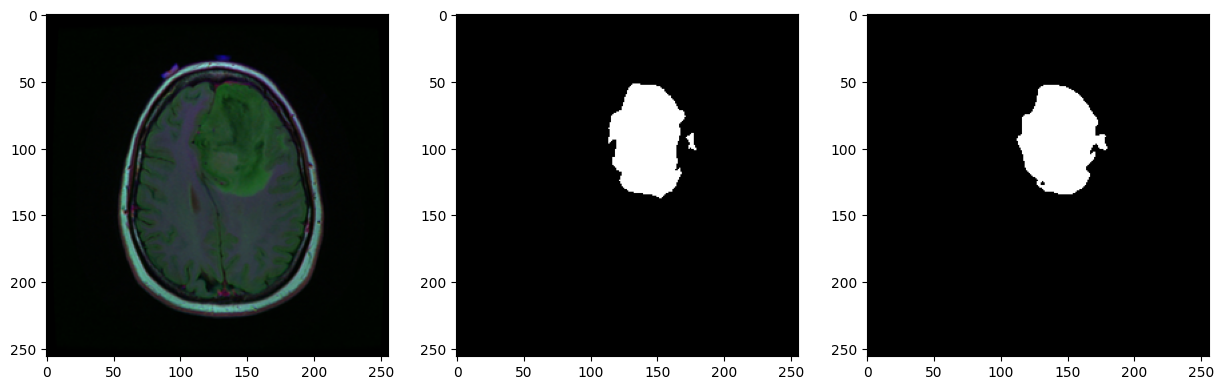

In [11]:
to_tensor = torchvision.transforms.ToTensor()

i = random.randint(0, len(dataset))
sample = dataset[i]
while sample["diagnosis"] == 0:
    i = random.randint(0, len(dataset))
    sample = dataset[i]
x = to_tensor(sample["image"])
y = to_tensor(sample["mask"]).permute(1,2,0)

y_pred = model(x.unsqueeze(0).to("cpu"))
y_pred = y_pred.squeeze().detach().cpu()
y_pred = (y_pred > 0.5).float().numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x.cpu().numpy().transpose(1,2,0))
ax[1].imshow(y.cpu().numpy().squeeze(), cmap="gray")
ax[2].imshow(y_pred, cmap="gray")